# imports


In [25]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import norm, rayleigh, gamma
import pickle
from tools import get_mids
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

In [32]:
from scipy.interpolate import RegularGridInterpolator

# loading effective areas


In [89]:
aeffs = pd.read_pickle("../resources/aeff_cluster_nuecc_with-eq.pickle")


In [90]:
aeffs

,,,aeff_hist,equatorial
hit_threshold,module_threshold,spacing,,
1,1,50.0,"[[1.249479195733076, 4.129317366419579, 9.5949...","[[1.0402923906980643, 3.708273351916866, 8.988..."
2,1,50.0,"[[0.32049806288254773, 1.3692028031650318, 4.6...","[[0.2670493215223058, 1.2268027895419604, 4.35..."
3,1,50.0,"[[0.10725602342869026, 0.5725277328717624, 2.2...","[[0.08940845754499858, 0.511996549741399, 2.09..."
4,1,50.0,"[[0.042451513429878955, 0.28138554824459944, 1...","[[0.03545598552767974, 0.25150891420762095, 1...."
5,1,50.0,"[[0.018193505755662413, 0.15361918307533273, 0...","[[0.01519542236900561, 0.13703750188728014, 0...."
...,...,...,...,...
1,5,200.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,200.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,5,200.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## binning

In [91]:
aeff = aeffs.iloc[0]["equatorial"].T # for testing
logE_bins = np.linspace(2, 6, 21)
sindec_bins = np.linspace(-1, 1, 20)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

20 log_10(energy) bins
19 declination bins


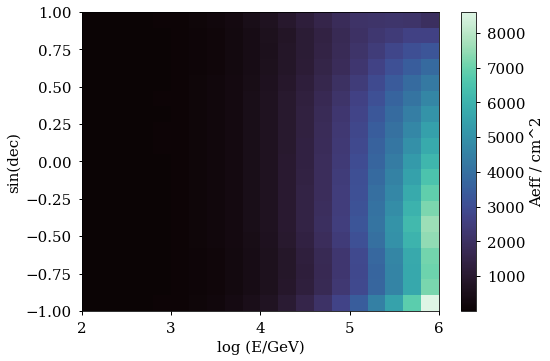

In [92]:
plt.pcolormesh(logE_bins, sindec_bins, aeff.T)
plt.xlabel("log (E/GeV)")
plt.ylabel("sin(dec)")
cb = plt.colorbar()
cb.set_label("Aeff / cm^2")


# background

In [79]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["nue_conv"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

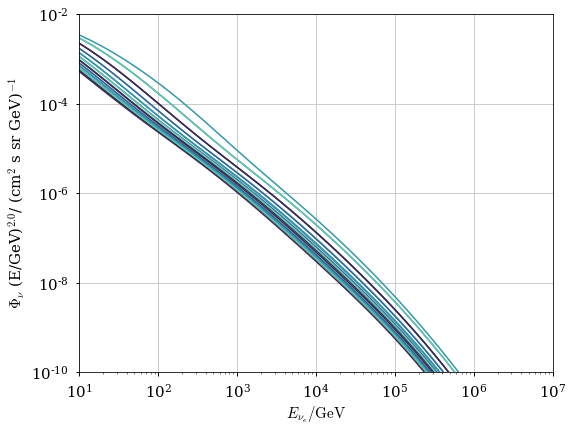

In [80]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{{{0}}} / {{\rm GeV}}$".format(r"\nu_e"))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# energy resolution

In [81]:
eres_df = pd.read_pickle("../resources/optimization_resolutions.pickle")

# NGC1068 - source parameters

In [82]:
from settings import ngc1068

In [83]:
def array_source_interp(dec, array):
    low_ind = np.digitize(np.sin(dec), sindec_bins) - 1

    if low_ind >= (len(sindec_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if sindec_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [sindec_mids[low_ind], sindec_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


In [94]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")

# analysis region in distance to source
delta_psi = 2

In [95]:
from fluxes import astro_flux

In [96]:
aeff_factor_signal = (
    array_source_interp(ngc1068.dec.rad, aeff) * LIVETIME * ewidth
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
    smear_energy=False
)
print(np.sum(k_s))


3.7127761665202934
